# Task 3.1

### Imports

In [29]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


### Data Generation

In [30]:
class NoisyXORDataset(Dataset):
    """
    Noisy XOR dataset as defined in the assignment:
    (x1, x2, y) = (m1 + s * η1, m2 + s * η2, m1 xor m2),
    where (m1, m2) are chosen from {(0,0), (0,1), (1,0), (1,1)}.
    """
    def __init__(self, n_samples=1000, s=0.1, seed=None):
        super().__init__()

        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random.default_rng()

        # Cluster centers
        centers = np.array([[0, 0],
                            [0, 1],
                            [1, 0],
                            [1, 1]], dtype=np.float32)

        # Choose cluster centers with equal probability
        m_idx = rng.integers(0, 4, size=n_samples)
        m = centers[m_idx]

        # Add Gaussian noise
        noise = rng.normal(loc=0.0, scale=s, size=(n_samples, 2)).astype(np.float32)
        x = m + noise

        # Labels are XOR of the centers (no noise on labels)
        y = (m[:, 0].astype(int) ^ m[:, 1].astype(int)).astype(np.float32)

        # Store as tensors
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y).unsqueeze(1)  # shape (N, 1)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


### Visualization

In [31]:
def plot_dataset(dataset, title):
    x = dataset.x.numpy()
    y = dataset.y.numpy().ravel()

    plt.figure()
    plt.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.7, label="Class 0")
    plt.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.7, label="Class 1")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


### Feed Forward Model

In [32]:
class FeedForwardNet(nn.Module):
    """
    Simple feed forward network:

    2 inputs -> 3 hidden units with tanh -> 1 output unit with identity activation

    The logistic sigmoid is not applied here but is built into BCEWithLogitsLoss.
    """
    def __init__(self, input_dim=2, hidden_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)   # output layer with identity activation
        )

    def forward(self, x):
        return self.model(x)


### Training

In [33]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=1e-2):
    model.to(device)

    # BCEWithLogitsLoss combines a sigmoid layer with BCELoss
    # in a numerically stable way and should be used with raw logits.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        n_train = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)

        train_losses.append(running_train_loss / n_train)

        # Validation
        model.eval()
        running_val_loss = 0.0
        n_val = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = criterion(logits, yb)

                running_val_loss += loss.item() * xb.size(0)
                n_val += xb.size(0)

        val_losses.append(running_val_loss / n_val)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1:03d}: "
                  f"train loss {train_losses[-1]:.4f}, "
                  f"val loss {val_losses[-1]:.4f}")

    return train_losses, val_losses


def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE loss")
    plt.legend()
    plt.grid(True)
    plt.show()


### Result

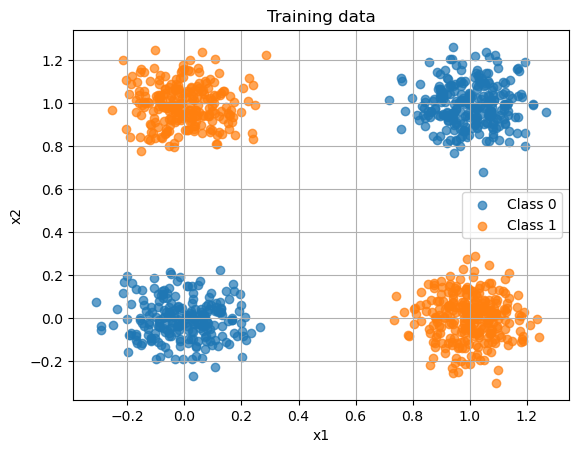

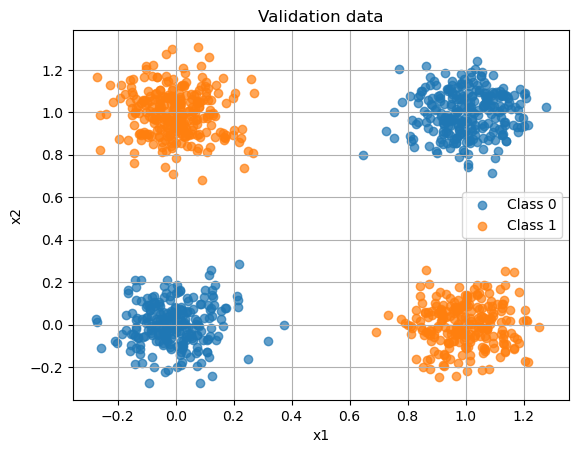

FeedForwardNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
Epoch 010: train loss 0.5830, val loss 0.5700
Epoch 020: train loss 0.3038, val loss 0.2867
Epoch 030: train loss 0.1076, val loss 0.1069
Epoch 040: train loss 0.0559, val loss 0.0582
Epoch 050: train loss 0.0353, val loss 0.0381
Epoch 060: train loss 0.0246, val loss 0.0276
Epoch 070: train loss 0.0182, val loss 0.0212
Epoch 080: train loss 0.0141, val loss 0.0171
Epoch 090: train loss 0.0112, val loss 0.0142
Epoch 100: train loss 0.0092, val loss 0.0122


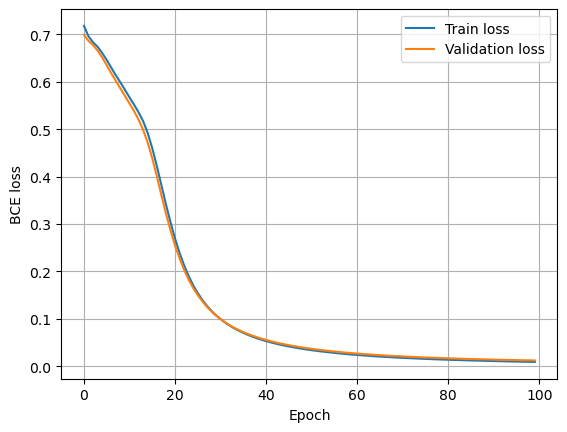

In [34]:
# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Hyperparameters
n_train = 1000
n_val = 1000
s = 0.1
batch_size = 64
num_epochs = 100
learning_rate = 1e-2

# Create datasets
train_dataset = NoisyXORDataset(n_samples=n_train, s=s, seed=0)
val_dataset = NoisyXORDataset(n_samples=n_val, s=s, seed=1)

# Visualize training and validation data (Figure 1 style)
plot_dataset(train_dataset, "Training data")
plot_dataset(val_dataset, "Validation data")

# DataLoaders with mini batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model
model = FeedForwardNet(input_dim=2, hidden_dim=3)
print(model)

# Train
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    lr=learning_rate
)

# Plot training and validation loss curves
plot_losses(train_losses, val_losses)


# Task 3.2

### flexible network class (0–3 hidden layers, width 1–3)

In [35]:
class FlexibleNet(nn.Module):
    """
    Feed-forward network with variable depth and width.

    num_hidden_layers = 0  -> logistic regression (no hidden layer)
    num_hidden_layers >= 1 -> MLP with that many hidden layers,
                              each of size hidden_dim and tanh activation.
    """
    def __init__(self, input_dim=2, hidden_dim=3, num_hidden_layers=1):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.Tanh())
            in_dim = hidden_dim

        # output layer (identity activation; sigmoid is in BCEWithLogitsLoss)
        layers.append(nn.Linear(in_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### Helper to Evaluation

In [36]:
def evaluate_loss(model, data_loader):
    """
    Compute mean BCE-with-logits loss on all samples in data_loader.
    """
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0.0
    n_samples = 0

    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

    return total_loss / n_samples


### Experiment

In [37]:
def run_single_experiment(
    depth,
    width,
    n_train=1000,
    n_eval=1000,
    s=0.1,
    num_epochs=100,
    lr=1e-2,
    batch_size=64,
    seed=1234
):
    """
    Train a FlexibleNet with given depth and width on noisy-xor,
    then evaluate its loss on a NEW dataset.

    Returns: scalar evaluation loss on the new dataset.
    """
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    # Training dataset
    train_dataset = NoisyXORDataset(n_samples=n_train, s=s, seed=None if seed is None else seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Validation during training (same distribution, different seed)
    val_dataset = NoisyXORDataset(n_samples=n_eval, s=s, seed=None if seed is None else seed + 1000)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = FlexibleNet(input_dim=2, hidden_dim=width, num_hidden_layers=depth).to(device)

    # Train (reusing your train_model from task 3.1)
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=lr
    )

    # New dataset for final evaluation (what the assignment asks for)
    eval_dataset = NoisyXORDataset(n_samples=n_eval, s=s, seed=None if seed is None else seed + 2000)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    eval_loss = evaluate_loss(model, eval_loader)
    return eval_loss


### Sweep over depths 0–3 and widths 1–3, compute mean and std on new data

In [38]:
import pandas as pd

depths = [0, 1, 2, 3]      # number of hidden layers
widths = [1, 2, 3]         # number of hidden units per hidden layer
num_runs = 5               # how many random runs per architecture (you can increase if you have compute)
s = 0.1                    # noise std (same as before)
n_train = 1000
n_eval = 1000
num_epochs = 100
learning_rate = 1e-2
batch_size = 64

results = []

for depth in depths:
    for width in widths:
        losses = []
        print(f"\nArchitecture: depth={depth}, width={width}")
        for r in range(num_runs):
            seed = 1000 * depth + 100 * width + r  # just a way to get different but reproducible seeds
            eval_loss = run_single_experiment(
                depth=depth,
                width=width,
                n_train=n_train,
                n_eval=n_eval,
                s=s,
                num_epochs=num_epochs,
                lr=learning_rate,
                batch_size=batch_size,
                seed=seed
            )
            losses.append(eval_loss)
            print(f"  run {r+1}/{num_runs}: eval loss = {eval_loss:.4f}")

        mean_loss = float(np.mean(losses))
        std_loss = float(np.std(losses, ddof=1))  # sample std

        print(f"  -> mean eval loss = {mean_loss:.4f}, std = {std_loss:.4f}")

        results.append({
            "depth": depth,
            "width": width,
            "mean_eval_loss": mean_loss,
            "std_eval_loss": std_loss
        })

results_df = pd.DataFrame(results)
results_df



Architecture: depth=0, width=1
Epoch 010: train loss 0.6911, val loss 0.6954
Epoch 020: train loss 0.6900, val loss 0.6983
Epoch 030: train loss 0.6900, val loss 0.6991
Epoch 040: train loss 0.6900, val loss 0.6990
Epoch 050: train loss 0.6900, val loss 0.6994
Epoch 060: train loss 0.6899, val loss 0.6994
Epoch 070: train loss 0.6901, val loss 0.6989
Epoch 080: train loss 0.6902, val loss 0.6995
Epoch 090: train loss 0.6906, val loss 0.6996
Epoch 100: train loss 0.6899, val loss 0.6992
  run 1/5: eval loss = 0.6930
Epoch 010: train loss 0.6914, val loss 0.6950
Epoch 020: train loss 0.6913, val loss 0.6945
Epoch 030: train loss 0.6911, val loss 0.6948
Epoch 040: train loss 0.6912, val loss 0.6944
Epoch 050: train loss 0.6911, val loss 0.6942
Epoch 060: train loss 0.6912, val loss 0.6945
Epoch 070: train loss 0.6913, val loss 0.6948
Epoch 080: train loss 0.6912, val loss 0.6946
Epoch 090: train loss 0.6911, val loss 0.6947
Epoch 100: train loss 0.6915, val loss 0.6944
  run 2/5: eval lo

,depth,width,mean_eval_loss,std_eval_loss
0,0,1,0.695142,0.002363
1,0,2,0.694236,0.000843
2,0,3,0.694663,0.001265
3,1,1,0.483318,0.021258
4,1,2,0.306683,0.176301
5,1,3,0.076872,0.156942
6,2,1,0.482193,0.008123
7,2,2,0.073978,0.156446
8,2,3,0.071154,0.156839
9,3,1,0.485881,0.012889


In [39]:
# Nice overview: rows = depth, columns = width, values = mean eval loss
mean_table = results_df.pivot(index="depth", columns="width", values="mean_eval_loss")
std_table = results_df.pivot(index="depth", columns="width", values="std_eval_loss")

print("Mean evaluation loss:")
display(mean_table)

print("\nStd of evaluation loss:")
display(std_table)


Mean evaluation loss:


width,1,2,3
depth,,,
0,0.695142,0.694236,0.694663
1,0.483318,0.306683,0.076872
2,0.482193,0.073978,0.071154
3,0.485881,0.072803,0.001503



Std of evaluation loss:


width,1,2,3
depth,,,
0,0.002363,0.000843,0.001265
1,0.021258,0.176301,0.156942
2,0.008123,0.156446,0.156839
3,0.012889,0.158735,0.002095


# Task 3.4

In [40]:
def save_decision_boundaries_frame(models, titles, dataset, epoch, out_dir, grid_res=200):
    """
    Plot decision boundaries for a list of models side by side and save as one image.

    models: list of nn.Module
    titles: list of strings (same length as models)
    dataset: NoisyXORDataset (used for scatter points)
    epoch: int (current epoch, used for filename)
    out_dir: directory where the frame PNG will be saved
    """
    for m in models:
        m.eval()

    x = dataset.x.numpy()
    y = dataset.y.numpy().ravel()

    # Create grid
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.from_numpy(grid).float().to(device)

    with torch.no_grad():
        logits_list = [m(grid_tensor) for m in models]
        probs_list = [torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)
                      for logits in logits_list]

    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))

    if len(models) == 1:
        axes = [axes]

    for ax, probs, title in zip(axes, probs_list, titles):
        cf = ax.contourf(xx, yy, probs, levels=50, alpha=0.6)
        ax.scatter(x[y == 0, 0], x[y == 0, 1], label="Class 0", alpha=0.8)
        ax.scatter(x[y == 1, 0], x[y == 1, 1], label="Class 1", alpha=0.8)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(f"{title}\nEpoch {epoch}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()

    os.makedirs(out_dir, exist_ok=True)
    fname = os.path.join(out_dir, f"frame_{epoch:04d}.png")
    plt.savefig(fname, dpi=150)
    plt.close(fig)


In [41]:
def train_three_models_with_frames(
    models,
    titles,
    train_loader,
    vis_dataset,
    out_dir="frames_task3_4",
    num_epochs=200,
    lr=1e-2,
    snapshot_every=5
):
    """
    Train three models in parallel on the same data and save decision-boundary
    snapshots every 'snapshot_every' epochs.

    models: list of nn.Module
    titles: list of strings (same length)
    train_loader: DataLoader for training
    vis_dataset: NoisyXORDataset used for visualisation
    out_dir: folder to store PNG frames
    """
    assert len(models) == len(titles), "models and titles must have same length"

    criterion = nn.BCEWithLogitsLoss()
    optimizers = [
        torch.optim.Adam(m.parameters(), lr=lr) for m in models
    ]

    # Move models to device
    for m in models:
        m.to(device)

    # Save initial frame (epoch 0)
    save_decision_boundaries_frame(models, titles, vis_dataset, epoch=0, out_dir=out_dir)

    for epoch in range(1, num_epochs + 1):
        for m in models:
            m.train()

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            for m, opt in zip(models, optimizers):
                opt.zero_grad()
                logits = m(xb)
                loss = criterion(logits, yb)
                loss.backward()
                opt.step()

        if epoch % snapshot_every == 0:
            print(f"Epoch {epoch}/{num_epochs} – saving frame")
            save_decision_boundaries_frame(models, titles, vis_dataset, epoch=epoch, out_dir=out_dir)


In [42]:
# Visualisation dataset (used for the background scatter and grid)
vis_dataset = NoisyXORDataset(n_samples=1000, s=0.1, seed=1234)
train_loader = DataLoader(vis_dataset, batch_size=64, shuffle=True)

# Three architectures: underfit, reasonable, more complex
model_linear = FlexibleNet(input_dim=2, hidden_dim=1, num_hidden_layers=0)  # depth 0
model_mid    = FlexibleNet(input_dim=2, hidden_dim=2, num_hidden_layers=1)  # 1 hidden layer, width 2
model_deep   = FlexibleNet(input_dim=2, hidden_dim=3, num_hidden_layers=3)  # depth 3, width 3

models = [model_linear, model_mid, model_deep]
titles = [
    "Depth 0 (linear)",
    "Depth 1, width 2",
    "Depth 3, width 3"
]

train_three_models_with_frames(
    models=models,
    titles=titles,
    train_loader=train_loader,
    vis_dataset=vis_dataset,
    out_dir="frames_task3_4",
    num_epochs=200,
    lr=1e-2,
    snapshot_every=5   # adjust if you want more / fewer frames
)


Epoch 5/200 – saving frame
Epoch 10/200 – saving frame
Epoch 15/200 – saving frame
Epoch 20/200 – saving frame
Epoch 25/200 – saving frame
Epoch 30/200 – saving frame
Epoch 35/200 – saving frame
Epoch 40/200 – saving frame
Epoch 45/200 – saving frame
Epoch 50/200 – saving frame
Epoch 55/200 – saving frame
Epoch 60/200 – saving frame
Epoch 65/200 – saving frame
Epoch 70/200 – saving frame
Epoch 75/200 – saving frame
Epoch 80/200 – saving frame
Epoch 85/200 – saving frame
Epoch 90/200 – saving frame
Epoch 95/200 – saving frame
Epoch 100/200 – saving frame
Epoch 105/200 – saving frame
Epoch 110/200 – saving frame
Epoch 115/200 – saving frame
Epoch 120/200 – saving frame
Epoch 125/200 – saving frame
Epoch 130/200 – saving frame
Epoch 135/200 – saving frame
Epoch 140/200 – saving frame
Epoch 145/200 – saving frame
Epoch 150/200 – saving frame
Epoch 155/200 – saving frame
Epoch 160/200 – saving frame
Epoch 165/200 – saving frame
Epoch 170/200 – saving frame
Epoch 175/200 – saving frame
Epoch